# Bayesian Experimental Design for model selection

Script used to perform optimisation where a 8 step experiment is being design considering the average of the Bhattacharyya distances of RFP and GFP for the two models

   ............................................................................................................................................................................................................................................

### Import Required libraries

In [16]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
from numba import jit
import gaussianprocess as gp
from fitderiv import fitderiv
import genutils as gu
import datetime
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import math


### Model 1 Functions (ODEs, Steady State and Event based representation)
* Lugagne et. al. Model

In [17]:
@jit
def model1(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    
    if u_IPTG > y[0]:
        dInd_dt[0]=k_in_IPTG*(u_IPTG-y[0])
    else:
        dInd_dt[0]=k_out_IPTG*(u_IPTG-y[0])
    
    if u_aTc > y[2]:
        dInd_dt[1]=k_in_aTc*(u_aTc-y[1])
    else:
        dInd_dt[1]=k_out_aTc*(u_aTc-y[1])
    
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState1(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode1(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState1(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model1,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 2 Functions (ODEs, Steady State and Event based representation)
* Intermediate Model (Single rate, no degradation)

In [18]:
@jit
def model2(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0]);
    dInd_dt[1] = k_aTc*(u_aTc-y[1]);
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState2(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode2(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState2(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model2,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 3 Functions (ODEs, Steady State and Event based representation)
* Lucia's Model

In [19]:
@jit
def model3(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0])-0.0165*y[0];
    dInd_dt[1] = k_aTc*(u_aTc-y[1])-0.0165*y[1];
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState3(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(4)
    alpha[0] = (k_IPTG*u_IPTG)/(k_IPTG+0.0165)
    alpha[1] = (k_aTc*u_aTc)/(k_aTc+0.0165)
    alpha[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(alpha[1]/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(alpha[0]/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode3(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    
    y_al = SteadyState3(p,ivss) # Calculation of initial guesses for steady state
    
    ssv = odeint(model3,y_al,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]
        
        
        
    
    return(final)

### Functions to simulate the 3 models for all parameter draws

In [20]:
def solveALL (ts, pD, sp, inputs, ivss, pre, model):
    
    AllSol = np.empty((len(ts),len(pD[:,1])*2))
    AllSolTest = np.empty(((round(len(ts)/5)+1),len(pD[:,1])*2))
    for drawInd in range(0,len(pD[:,1])):
        
        p = pD[drawInd,:]
        if model == 'M1':
            temp = solve_coupled_ode1(ts, p, sp, inputs, ivss, pre)
        elif model == 'M2':
            temp = solve_coupled_ode2(ts, p, sp, inputs, ivss, pre)
        elif model == 'M3':
            temp = solve_coupled_ode3(ts, p, sp, inputs, ivss, pre)
        else:
            print('Please, select a correct model as M1, M2 or M3 for the desired one')

        AllSolTest[:,drawInd] = temp[:,2][::5]
        AllSolTest[:,drawInd+(len(pD[:,1]))] = temp[:,3][::5]

    return(AllSolTest)
    

### Example:

In [21]:
ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
inputs = np.empty(18) # What needs to be optimised    --> example: [1e-7,100,1,1e-7]*4+[1e-7,100]
evnT = [int(i) for i in list(np.linspace(0,(24*60),10))]
t = np.linspace(0,(24*60),(24*60)+1)
pM3 = np.asarray(pd.read_csv("ParametersCSV/draws_ALL_Model3.stan.csv"))

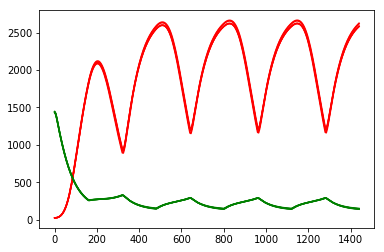

In [22]:
p = pM3[0:5,:]
test = solveALL(t,p,evnT,[1e-7,100,1,1e-7]*4+[1e-7,100],ivss,pre, 'M3')
plt.figure()
plt.plot(t[::5], test[:,0:5], 'r')
plt.plot(t[::5], test[:,5:10], 'g')
plt.show()

### Bhattacharyya distance function:

In [23]:

def BhattacharyyaDist (mu1, mu2, sd1, sd2):
    E = (sd1+sd2)/2
    Em1 = np.linalg.inv(E)
    dE = abs(np.linalg.det(E))

    t1 = np.matrix.transpose((np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))))
    t2 = np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))
    
    ft = (1/8)*t1*Em1*t2
    st = dE/np.sqrt(abs(np.linalg.det(sd1))*abs(np.linalg.det(sd2)))
    
    bhd = ft+0.5*np.log(st)
    
    return(float(bhd))



### Definition of the utility function:

In [24]:

def utility2 (IPTG1, IPTG2, IPTG3, IPTG4, IPTG5, IPTG6, IPTG7, IPTG8,
             aTc1, aTc2, aTc3, aTc4, aTc5, aTc6, aTc7, aTc8):
    
    # Definition of inputs for the ODEs
        
    inputs = [round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7,
              round(IPTG3,2)+1e-7, int(aTc3)+1e-7, round(IPTG4,2)+1e-7, int(aTc4)+1e-7,
              round(IPTG5,2)+1e-7, int(aTc5)+1e-7, round(IPTG6,2)+1e-7, int(aTc6)+1e-7,
              round(IPTG7,2)+1e-7, int(aTc7)+1e-7, round(IPTG8,2)+1e-7, int(aTc8)+1e-7]
    
    # Initial values for steady state and inputs
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(24*60),9))]
    t =  np.linspace(0,(24*60),(24*60)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
    solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
    solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(24*60),round(24*60/5)+1)
    
    muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2.std(axis = 1)
    muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
    sdG3 = GFP_M2.std(axis = 1)
    muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1.std(axis = 1)
    muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
    sdG2 = GFP_M1.std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
    gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
    gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
    gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
    gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    
    g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
    bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Utility function value
    u_B = (bdR+bdG)/2

    return(u_B)
    


### Bayesian Optimisation: 

In [25]:
# Bounded region of parameter space

pbounds = {'IPTG1': (0, 1), 'IPTG2': (0, 1), 'IPTG3': (0, 1), 'IPTG4': (0, 1),
           'IPTG5': (0, 1), 'IPTG6': (0, 1), 'IPTG7': (0, 1), 'IPTG8': (0, 1),
           'aTc1': (0, 100), 'aTc2': (0, 100), 'aTc3': (0, 100), 'aTc4': (0, 100), 
           'aTc5': (0, 100), 'aTc6': (0, 100), 'aTc7': (0, 100), 'aTc8': (0, 100)}


Setting Bayesian Optimisation with our utility function

In [26]:
optimizer3 = BayesianOptimization(
    f=utility2,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1324,
) 

Begin optimisation rutine

In [36]:
optimizer3.maximize(
    init_points=0,
    n_iter=200,
    alpha=1e-2,
    n_restarts_optimizer=3, 
#     acq="ei", 
#     xi=1e-4
)

|   iter    |  target   |   IPTG1   |   IPTG2   |   IPTG3   |   IPTG4   |   IPTG5   |   IPTG6   |   IPTG7   |   IPTG8   |   aTc1    |   aTc2    |   aTc3    |   aTc4    |   aTc5    |   aTc6    |   aTc7    |   aTc8    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  805      |  1.905e+0 |  0.4114   |  0.3036   |  0.1825   |  0.7667   |  0.3799   |  0.862    |  0.6085   |  0.7604   |  28.71    |  44.91    |  24.3     |  28.0     |  11.32    |  33.72    |  75.05    |  17.72    |
|  806      |  553.5    |  0.6235   |  0.1954   |  0.6549   |  0.7435   |  0.4729   |  0.1823   |  0.2805   |  0.05309  |  95.05    |  52.52    |  50.63    |  43.16    |  85.04    |  5.653    |  15.52    |  40.43    |
|  807      |  1.202e+0 |  0.3301   |  0.1386   |  0.4198   |  0.2294   |  0.3129   |  0.9455   |  0.5105   |  0.3283   |  17.32

|  814      |  5.377e+0 |  0.7692   |  0.004808 |  0.8723   |  0.7472   |  0.5975   |  0.6842   |  0.1327   |  0.8354   |  23.03    |  40.26    |  13.79    |  18.46    |  9.379    |  42.22    |  69.76    |  12.61    |
|  815      |  3.778e+0 |  0.5269   |  0.2549   |  0.45     |  0.1444   |  0.2208   |  0.9905   |  0.7255   |  0.9794   |  95.49    |  47.97    |  60.87    |  60.92    |  30.25    |  40.14    |  21.71    |  53.69    |
|  816      |  3.731e+0 |  0.128    |  0.4428   |  0.3929   |  0.2514   |  0.5454   |  0.04484  |  0.3456   |  0.2613   |  21.72    |  8.827    |  51.99    |  46.71    |  6.672    |  15.33    |  10.56    |  14.72    |
|  817      |  5.824e+0 |  0.7442   |  0.2363   |  0.3387   |  0.5058   |  0.3993   |  0.01627  |  0.1794   |  0.1338   |  36.48    |  40.34    |  5.303    |  27.41    |  45.8     |  19.63    |  80.57    |  42.92    |
|  818      |  3.118e+0 |  0.2379   |  0.7241   |  0.9069   |  0.2755   |  0.7414   |  0.1795   |  0.9692   |  0.5734   |  87.52

|  825      |  3.549e+0 |  0.166    |  0.5958   |  0.927    |  0.5194   |  0.188    |  0.3749   |  0.5592   |  0.6692   |  14.23    |  21.13    |  25.76    |  58.99    |  41.41    |  24.18    |  12.51    |  17.78    |
|  826      |  7.318e+0 |  0.6857   |  0.1446   |  0.8416   |  0.4792   |  0.3865   |  0.239    |  0.4772   |  0.7681   |  14.47    |  24.04    |  45.49    |  47.76    |  14.19    |  15.89    |  10.27    |  5.615    |
|  827      |  2.288e+0 |  0.5897   |  0.1377   |  0.6552   |  0.1426   |  0.7433   |  0.6084   |  0.1883   |  0.5184   |  16.29    |  32.56    |  9.408    |  34.03    |  42.22    |  51.03    |  29.57    |  75.69    |
|  828      |  4.143e+0 |  0.6211   |  0.6419   |  0.3159   |  0.397    |  0.6282   |  0.451    |  0.8192   |  0.3201   |  30.0     |  7.49     |  17.98    |  14.32    |  46.28    |  46.93    |  11.0     |  92.59    |
|  829      |  9.071e+0 |  0.8814   |  0.8713   |  0.2949   |  0.9565   |  0.1408   |  0.1213   |  0.3684   |  0.7793   |  72.93

|  837      |  1.721e+0 |  0.3993   |  0.9379   |  0.3638   |  0.7753   |  0.1187   |  0.6885   |  0.8933   |  0.5388   |  92.51    |  37.69    |  49.97    |  36.2     |  35.83    |  34.91    |  5.696    |  44.15    |
|  838      |  4.845e+0 |  0.745    |  0.1166   |  0.7002   |  0.7967   |  0.8896   |  0.454    |  0.4788   |  0.7924   |  30.6     |  38.7     |  4.421    |  19.41    |  48.13    |  20.89    |  77.16    |  47.9     |
|  839      |  4.431e+0 |  0.132    |  0.3456   |  0.7838   |  0.3951   |  0.3131   |  0.9687   |  0.8171   |  0.4031   |  28.02    |  37.37    |  34.37    |  13.72    |  88.72    |  92.27    |  22.75    |  68.78    |
|  840      |  1.043e+0 |  0.9831   |  0.4282   |  0.7944   |  0.4329   |  0.8704   |  0.1399   |  0.8474   |  0.7808   |  78.37    |  55.17    |  7.013    |  14.04    |  13.23    |  28.62    |  11.15    |  44.49    |
|  841      |  747.4    |  0.7551   |  0.1579   |  0.0921   |  0.00339  |  0.5193   |  0.2341   |  0.1508   |  0.4807   |  81.66

|  848      |  7.394e+0 |  0.07647  |  0.3303   |  0.2433   |  0.4848   |  0.3523   |  0.1779   |  0.9923   |  0.4592   |  77.61    |  37.39    |  48.47    |  3.138    |  26.34    |  26.48    |  52.61    |  12.09    |
|  849      |  2.2e+03  |  0.357    |  0.5434   |  0.002764 |  0.5709   |  0.2863   |  0.4509   |  0.8576   |  0.07054  |  4.013    |  24.44    |  47.87    |  51.13    |  24.7     |  16.41    |  22.15    |  10.31    |
|  850      |  1.902e+0 |  0.1937   |  0.8891   |  0.2944   |  0.1773   |  0.03494  |  0.7311   |  0.5643   |  0.8137   |  8.104    |  34.97    |  36.89    |  47.23    |  23.9     |  17.7     |  3.293    |  9.621    |
|  851      |  1.397e+0 |  0.2293   |  0.9171   |  0.517    |  0.03089  |  0.04632  |  0.8782   |  0.4159   |  0.2944   |  77.29    |  73.98    |  6.14     |  17.32    |  13.74    |  37.22    |  31.86    |  36.9     |
|  852      |  8.782e+0 |  0.5165   |  0.8125   |  0.5715   |  0.67     |  0.9474   |  0.4437   |  0.8505   |  0.8843   |  32.06

|  859      |  1.12e+04 |  0.8328   |  0.3179   |  0.1163   |  0.845    |  0.1525   |  0.2814   |  0.2902   |  0.7539   |  17.45    |  38.38    |  45.48    |  34.1     |  28.92    |  5.385    |  9.915    |  29.7     |
|  860      |  3.051e+0 |  0.7095   |  0.2552   |  0.06437  |  0.2823   |  0.03477  |  0.2699   |  0.3174   |  0.5592   |  1.013    |  31.18    |  39.39    |  50.84    |  26.62    |  11.82    |  12.68    |  23.23    |
|  861      |  3.895e+0 |  0.322    |  0.2061   |  0.4794   |  0.2446   |  0.644    |  0.5283   |  0.9473   |  0.8748   |  2.185    |  21.83    |  43.29    |  43.98    |  29.78    |  14.59    |  21.89    |  15.58    |
|  862      |  1.098e+0 |  0.7962   |  0.8265   |  0.08227  |  0.6607   |  0.9545   |  0.5232   |  0.2883   |  0.9474   |  31.52    |  44.82    |  28.56    |  15.27    |  19.29    |  18.61    |  72.34    |  53.93    |
|  863      |  5.445e+0 |  0.7153   |  0.2473   |  0.03069  |  0.1337   |  0.7586   |  0.6049   |  0.6953   |  0.3994   |  11.29

|  869      |  1.808e+0 |  0.5251   |  0.6795   |  0.2606   |  0.1337   |  0.1599   |  0.4786   |  0.188    |  0.9548   |  75.06    |  65.72    |  17.95    |  18.43    |  26.64    |  28.73    |  5.935    |  43.57    |
|  870      |  7.948e+0 |  0.125    |  0.675    |  0.2655   |  0.1058   |  0.891    |  0.6369   |  0.8675   |  0.8386   |  15.06    |  42.28    |  36.99    |  53.45    |  40.61    |  9.013    |  21.43    |  14.31    |
|  871      |  6.151e+0 |  0.6705   |  0.4892   |  0.6209   |  0.072    |  0.9381   |  0.2245   |  0.2126   |  0.9793   |  11.34    |  33.46    |  65.93    |  63.67    |  25.41    |  5.53     |  6.665    |  29.54    |
|  872      |  5.594e+0 |  0.8053   |  0.8968   |  0.3376   |  0.3686   |  0.2769   |  0.9731   |  0.463    |  0.5987   |  21.71    |  68.25    |  13.0     |  4.129    |  18.06    |  21.63    |  70.34    |  38.04    |
|  873      |  4.078e+0 |  0.9141   |  0.1383   |  0.198    |  0.084    |  0.6777   |  0.5126   |  0.1392   |  0.7264   |  27.04

|  879      |  2.319e+0 |  0.2828   |  0.1046   |  0.6755   |  0.994    |  0.3634   |  0.1279   |  0.401    |  0.8501   |  97.08    |  56.12    |  58.24    |  31.32    |  37.42    |  46.42    |  19.33    |  54.33    |
|  880      |  846.1    |  0.8967   |  0.5441   |  0.8549   |  0.5143   |  0.493    |  0.1173   |  0.2733   |  0.7842   |  13.89    |  40.39    |  27.27    |  51.79    |  62.42    |  71.17    |  88.52    |  19.23    |
|  881      |  5.711e+0 |  0.6155   |  0.2346   |  0.3602   |  0.7164   |  0.7882   |  0.2177   |  0.713    |  0.6856   |  32.39    |  31.56    |  0.939    |  11.06    |  41.41    |  22.26    |  81.21    |  60.84    |
|  882      |  3.796e+0 |  0.5384   |  0.472    |  0.08722  |  0.6306   |  0.5052   |  0.7748   |  0.7248   |  0.3777   |  1.726    |  22.62    |  44.45    |  40.4     |  30.59    |  12.48    |  25.61    |  16.96    |
|  883      |  7.115e+0 |  0.7376   |  0.8388   |  0.7027   |  0.661    |  0.9814   |  0.6962   |  0.2121   |  0.7182   |  16.05

|  889      |  1.71e+04 |  0.07618  |  0.4541   |  0.1913   |  0.4043   |  0.9382   |  0.741    |  0.7958   |  0.4894   |  20.88    |  28.53    |  48.2     |  28.15    |  26.34    |  14.62    |  7.49     |  26.77    |
|  890      |  868.9    |  0.8516   |  0.7136   |  0.6388   |  0.8957   |  0.02278  |  0.01649  |  0.07871  |  0.6053   |  22.99    |  76.35    |  1.135    |  8.35     |  19.79    |  23.76    |  70.0     |  43.62    |
|  891      |  3.301e+0 |  0.7853   |  0.5284   |  0.06611  |  0.1657   |  0.7879   |  0.5091   |  0.4567   |  0.5948   |  76.1     |  63.6     |  6.472    |  2.764    |  1.297    |  29.7     |  35.06    |  44.63    |
|  892      |  1.51e+03 |  0.5445   |  0.9205   |  0.5904   |  0.185    |  0.8709   |  0.9855   |  0.03305  |  0.2405   |  76.92    |  32.14    |  36.54    |  0.1184   |  25.2     |  24.29    |  60.35    |  16.16    |
|  893      |  1.041e+0 |  0.7115   |  0.3469   |  0.5361   |  0.5322   |  0.5748   |  0.7889   |  0.5248   |  0.3933   |  31.8 

|  898      |  3.074e+0 |  0.9655   |  0.6331   |  0.7109   |  0.2715   |  0.817    |  0.08537  |  0.8605   |  0.1188   |  25.47    |  30.89    |  12.61    |  11.42    |  47.15    |  23.58    |  75.96    |  54.5     |
|  899      |  3.968e+0 |  0.9965   |  0.04335  |  0.4077   |  0.1493   |  0.2792   |  0.8369   |  0.575    |  0.2487   |  16.23    |  41.27    |  34.09    |  57.93    |  45.1     |  8.753    |  28.8     |  16.92    |
|  900      |  3.956e+0 |  0.6475   |  0.3027   |  0.02193  |  0.8172   |  0.8014   |  0.3929   |  0.07915  |  0.06785  |  15.74    |  35.35    |  51.7     |  41.09    |  19.4     |  7.212    |  4.268    |  35.66    |
|  901      |  1.083e+0 |  0.01269  |  0.09724  |  0.2816   |  0.2895   |  0.5453   |  0.01254  |  0.2945   |  0.5313   |  16.45    |  30.9     |  57.47    |  50.28    |  29.01    |  16.78    |  12.38    |  29.68    |
|  902      |  6.431e+0 |  0.959    |  0.4524   |  0.1045   |  0.5152   |  0.8992   |  0.8179   |  0.7185   |  0.4331   |  78.52

|  909      |  8.406e+0 |  0.8224   |  0.8874   |  0.257    |  0.8936   |  0.783    |  0.6843   |  0.1857   |  0.613    |  30.58    |  43.14    |  21.1     |  28.72    |  78.42    |  40.51    |  91.68    |  35.69    |
|  910      |  7.285e+0 |  0.3531   |  0.5646   |  0.7691   |  0.3657   |  0.8731   |  0.18     |  0.2993   |  0.4991   |  76.42    |  34.2     |  44.9     |  4.863    |  21.45    |  23.48    |  52.34    |  4.427    |
|  911      |  6.921e+0 |  0.4216   |  0.8775   |  0.3851   |  0.5603   |  0.5302   |  0.5111   |  0.4868   |  0.9063   |  6.109    |  27.1     |  32.33    |  55.45    |  27.98    |  25.95    |  24.32    |  19.36    |
|  912      |  1.002e+0 |  0.8024   |  0.741    |  0.9281   |  0.2358   |  0.9835   |  0.9702   |  0.9058   |  0.4171   |  12.2     |  24.46    |  37.08    |  44.8     |  33.67    |  15.42    |  10.34    |  10.56    |
|  913      |  2.647e+0 |  0.5415   |  0.2072   |  0.6356   |  0.4725   |  0.7329   |  0.5725   |  0.4693   |  0.00354  |  20.86

|  920      |  1.522e+0 |  0.4175   |  0.1929   |  0.6592   |  0.831    |  0.5658   |  0.6186   |  0.3965   |  0.1176   |  40.13    |  39.0     |  16.42    |  14.42    |  41.84    |  28.97    |  82.34    |  56.55    |
|  921      |  1.176e+0 |  0.1911   |  0.4365   |  0.9385   |  0.7035   |  0.6028   |  0.02003  |  0.1702   |  0.3791   |  12.07    |  27.96    |  39.18    |  65.09    |  30.07    |  13.06    |  14.25    |  16.35    |
|  922      |  9.318e+0 |  0.004749 |  0.8406   |  0.1249   |  0.5821   |  0.5996   |  0.4466   |  0.1325   |  0.2173   |  12.1     |  14.06    |  7.641    |  24.98    |  50.74    |  96.75    |  25.95    |  5.669    |
|  923      |  3.927e+0 |  0.9323   |  0.2715   |  0.6513   |  0.03836  |  0.4103   |  0.6765   |  0.5257   |  0.6196   |  83.87    |  27.21    |  45.47    |  11.47    |  14.22    |  23.6     |  59.58    |  12.39    |
|  924      |  1.936e+0 |  0.494    |  0.9055   |  0.6491   |  0.8036   |  0.9216   |  0.8395   |  0.7334   |  0.628    |  0.293

|  929      |  3.509e+0 |  0.671    |  0.07261  |  0.6094   |  0.04355  |  0.763    |  0.8095   |  0.3003   |  0.6515   |  3.736    |  31.77    |  49.79    |  35.09    |  23.36    |  32.82    |  4.616    |  19.98    |
|  930      |  1.208e+0 |  0.4894   |  0.36     |  0.4934   |  0.8911   |  0.8481   |  0.008635 |  0.7102   |  0.7755   |  33.24    |  42.58    |  21.19    |  27.95    |  19.49    |  34.58    |  78.33    |  14.4     |
|  931      |  3.73e+03 |  0.4428   |  0.6546   |  0.6224   |  0.1597   |  0.246    |  0.6363   |  0.8664   |  0.2383   |  79.15    |  26.67    |  30.62    |  12.75    |  23.86    |  23.56    |  58.64    |  9.001    |
|  932      |  2.457e+0 |  0.2913   |  0.9312   |  0.02595  |  0.861    |  0.3978   |  0.7867   |  0.2449   |  0.01776  |  11.14    |  25.98    |  47.34    |  63.97    |  28.81    |  24.0     |  7.547    |  14.23    |
|  933      |  239.6    |  0.4154   |  0.6634   |  0.01086  |  0.1592   |  0.9665   |  0.8917   |  0.8829   |  0.4239   |  74.93

|  939      |  3.574e+0 |  0.7919   |  0.4073   |  0.7201   |  0.945    |  0.403    |  0.1416   |  0.9646   |  0.8611   |  33.59    |  35.52    |  5.427    |  15.62    |  46.38    |  36.54    |  79.49    |  47.12    |
|  940      |  1.273e+0 |  0.7514   |  0.8178   |  0.6024   |  0.5189   |  0.4791   |  0.1417   |  0.8542   |  0.4728   |  13.58    |  19.91    |  47.41    |  45.14    |  7.502    |  13.76    |  11.6     |  8.763    |
|  941      |  6.59e+03 |  0.1987   |  0.1946   |  0.576    |  0.5605   |  0.9417   |  0.1529   |  0.9351   |  0.452    |  27.62    |  46.16    |  29.79    |  26.98    |  16.68    |  34.41    |  67.19    |  16.32    |
|  942      |  7.519e+0 |  0.2727   |  0.2526   |  0.4669   |  0.8493   |  0.7577   |  0.4861   |  0.1262   |  0.6008   |  10.72    |  17.69    |  36.75    |  52.41    |  32.11    |  22.49    |  22.17    |  16.17    |
|  943      |  1.038e+0 |  0.3878   |  0.4277   |  0.5458   |  0.8765   |  0.4784   |  0.6389   |  0.7472   |  0.7812   |  22.35

|  948      |  1.07e+03 |  0.1781   |  0.8209   |  0.2548   |  0.06264  |  0.5858   |  0.339    |  0.5733   |  0.4216   |  71.6     |  32.66    |  56.02    |  6.021    |  34.86    |  15.3     |  49.24    |  10.45    |
|  949      |  3.467e+0 |  0.7439   |  0.1175   |  0.1844   |  0.00687  |  0.1343   |  0.1454   |  0.2328   |  0.7119   |  54.76    |  77.83    |  94.8     |  15.51    |  40.27    |  47.82    |  55.0     |  33.91    |
|  950      |  2.699e+0 |  0.1237   |  0.03244  |  0.4231   |  0.1192   |  0.2397   |  0.3351   |  0.01837  |  0.9404   |  26.35    |  26.07    |  2.103    |  11.53    |  33.89    |  30.68    |  79.47    |  59.91    |
|  951      |  1.382e+0 |  0.6318   |  0.956    |  0.333    |  0.02336  |  0.6694   |  0.9179   |  0.05608  |  0.9819   |  25.52    |  36.02    |  47.48    |  37.12    |  21.89    |  15.63    |  6.927    |  23.83    |
|  952      |  1.079e+0 |  0.5318   |  0.4692   |  0.7799   |  0.6581   |  0.921    |  0.1518   |  0.4482   |  0.1293   |  71.54

|  959      |  5.037e+0 |  0.4581   |  0.8809   |  0.4906   |  0.5272   |  0.2135   |  0.7318   |  0.9896   |  0.6509   |  77.64    |  21.89    |  36.86    |  11.94    |  19.68    |  38.26    |  63.73    |  18.94    |
|  960      |  7.805e+0 |  0.2285   |  0.6891   |  0.3475   |  0.4362   |  0.937    |  0.7105   |  0.7139   |  0.7664   |  28.28    |  43.04    |  37.74    |  16.75    |  19.2     |  11.37    |  67.06    |  54.99    |
|  961      |  2.633e+0 |  0.9921   |  0.6474   |  0.6708   |  0.9926   |  0.3061   |  0.3517   |  0.1714   |  0.8955   |  8.718    |  18.79    |  35.69    |  56.51    |  31.04    |  7.813    |  15.34    |  18.65    |
|  962      |  8.079e+0 |  0.3182   |  0.7318   |  0.919    |  0.3464   |  0.1968   |  0.3095   |  0.2622   |  0.01125  |  9.306    |  13.52    |  39.45    |  56.62    |  4.06     |  16.4     |  16.11    |  19.88    |
|  963      |  2.54e+04 |  0.944    |  0.3157   |  0.2222   |  0.6972   |  0.5622   |  0.7046   |  0.7204   |  0.5467   |  79.98

|  969      |  1.995e+0 |  0.5144   |  0.3512   |  0.9052   |  0.6622   |  0.4482   |  0.2039   |  0.01083  |  0.2297   |  41.38    |  12.98    |  13.03    |  7.11     |  46.62    |  41.46    |  10.75    |  79.62    |
|  970      |  6.866e+0 |  0.6691   |  0.5492   |  0.9044   |  0.6404   |  0.7103   |  0.2687   |  0.542    |  0.6375   |  90.34    |  57.67    |  61.76    |  52.6     |  31.89    |  26.55    |  13.67    |  48.1     |
|  971      |  8.715e+0 |  0.3172   |  0.9199   |  0.5082   |  0.9205   |  0.08516  |  0.8281   |  0.7309   |  0.6995   |  10.6     |  36.97    |  59.22    |  59.01    |  27.21    |  16.94    |  9.498    |  24.42    |
|  972      |  7.86e+03 |  0.4333   |  0.4367   |  0.8643   |  0.8384   |  0.6284   |  0.7503   |  0.705    |  0.1238   |  21.33    |  23.26    |  41.43    |  18.06    |  72.55    |  95.87    |  27.96    |  50.32    |
|  973      |  2.728e+0 |  0.4058   |  0.481    |  0.1838   |  0.4814   |  0.8381   |  0.7715   |  0.04891  |  0.6062   |  85.13

|  979      |  1.592e+0 |  0.215    |  0.09812  |  0.492    |  0.8503   |  0.1862   |  0.2581   |  0.1385   |  0.04516  |  7.627    |  31.77    |  43.63    |  61.62    |  33.7     |  11.45    |  16.07    |  16.83    |
|  980      |  4.297e+0 |  0.4159   |  0.1496   |  0.5517   |  0.03588  |  0.07515  |  0.1373   |  0.09948  |  0.1939   |  17.23    |  25.56    |  10.02    |  19.7     |  50.75    |  65.66    |  35.07    |  98.74    |
|  981      |  546.6    |  0.6702   |  0.2972   |  0.08024  |  0.6577   |  0.6373   |  0.14     |  0.2675   |  0.004911 |  19.58    |  77.81    |  94.06    |  84.01    |  3.818    |  27.29    |  19.78    |  32.75    |
|  982      |  2.015e+0 |  0.2918   |  0.7672   |  0.3923   |  0.904    |  0.2944   |  0.7248   |  0.01761  |  0.8975   |  72.53    |  67.9     |  14.74    |  2.033    |  6.124    |  31.82    |  31.16    |  40.25    |
|  983      |  1.92e+03 |  0.5846   |  0.1694   |  0.8737   |  0.6855   |  0.5478   |  0.1889   |  0.3997   |  0.6566   |  66.98

|  988      |  5.915e+0 |  0.5183   |  0.5676   |  0.03996  |  0.8184   |  0.28     |  0.08358  |  0.3866   |  0.3595   |  78.33    |  70.15    |  4.137    |  14.08    |  17.19    |  28.57    |  31.35    |  28.27    |
|  989      |  329.0    |  0.2622   |  0.6309   |  0.7453   |  0.1008   |  0.2755   |  0.4532   |  0.08114  |  0.1589   |  95.08    |  41.64    |  44.07    |  58.44    |  47.35    |  36.31    |  75.07    |  24.88    |
|  990      |  2.368e+0 |  0.036    |  0.1308   |  0.7176   |  0.5144   |  0.814    |  0.07977  |  0.9209   |  0.9478   |  86.89    |  55.54    |  61.06    |  53.1     |  32.71    |  26.59    |  23.29    |  48.14    |
|  991      |  1.783e+0 |  0.1724   |  0.797    |  0.3892   |  0.4      |  0.7638   |  0.1033   |  0.7399   |  0.8104   |  32.38    |  40.23    |  32.95    |  36.06    |  81.76    |  38.11    |  93.52    |  42.65    |
|  992      |  9.976e+0 |  0.2077   |  0.0285   |  0.02023  |  0.2151   |  0.4916   |  0.7281   |  0.8927   |  0.3806   |  22.21

|  998      |  4.25e+03 |  0.5814   |  0.004632 |  0.2635   |  0.3727   |  0.1746   |  0.2686   |  0.8456   |  0.7977   |  32.29    |  37.03    |  10.47    |  4.588    |  41.86    |  26.59    |  71.21    |  57.42    |
|  999      |  1.421e+0 |  0.6253   |  0.07026  |  0.3649   |  0.06289  |  0.8254   |  0.5102   |  0.928    |  0.7766   |  2.049    |  31.22    |  52.65    |  56.6     |  20.12    |  6.255    |  16.08    |  9.314    |
|  1000     |  5.355e+0 |  0.799    |  0.6778   |  0.8232   |  0.8029   |  0.3696   |  0.3587   |  0.08364  |  0.4334   |  3.569    |  44.7     |  43.65    |  50.39    |  26.26    |  9.016    |  11.82    |  20.21    |
|  1001     |  6.327e+0 |  0.8283   |  0.3071   |  0.6841   |  0.4808   |  0.02938  |  0.1196   |  0.6269   |  0.2515   |  17.21    |  30.48    |  61.5     |  53.31    |  15.31    |  10.44    |  11.85    |  11.23    |
|  1002     |  8.483e+0 |  0.3428   |  0.9838   |  0.9882   |  0.343    |  0.6041   |  0.1748   |  0.7231   |  0.5274   |  12.56

In [37]:
# Save results obtained
with open('config8sAverage3.optim', 'wb') as config_optim_file:
 
    pickle.dump(optimizer3, config_optim_file)
    

In [38]:
# Best utility value generated
print(optimizer3.max)

{'target': 60649.509917138035, 'params': {'IPTG1': 0.24677918047153624, 'IPTG2': 0.5197999553366234, 'IPTG3': 0.7691276174555177, 'IPTG4': 0.7839889207162871, 'IPTG5': 0.528067779032697, 'IPTG6': 0.3513633889119959, 'IPTG7': 0.27136897862919485, 'IPTG8': 0.24643742439620653, 'aTc1': 10.325966412292232, 'aTc2': 31.78817187906858, 'aTc3': 53.64275658835825, 'aTc4': 45.907927000199976, 'aTc5': 27.133164837152812, 'aTc6': 30.749947998304727, 'aTc7': 7.537572141133175, 'aTc8': 7.603286402472886}}


Plot best utility value so far per iteration: 

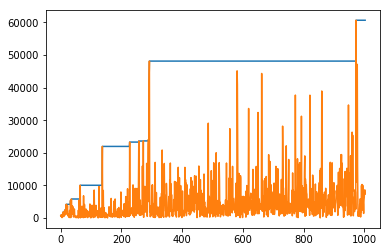

In [39]:
v = []
for i, res in enumerate(optimizer3.res):
    v.append(res['target'])
    
vn = []
for i, val in enumerate(v):
    mv = max(v[0:i+1])
    vn.append(mv)
    
plt.figure()
plt.plot(vn)
plt.plot(v)
plt.show()

In [42]:
df = pd.DataFrame({
    'CFV': vn})
df.to_csv('bestCFV_Iter_8S_Average.csv')

In [43]:
df = pd.DataFrame({
    'CFV': v})
df.to_csv('CFV_Iter_8S_Average.csv')

### Check results with plot

In [40]:
inputs = [round(optimizer3.max['params']['IPTG1'], 2)+1e-7, int(optimizer3.max['params']['aTc1'])+1e-7, 
          round(optimizer3.max['params']['IPTG2'], 2)+1e-7, int(optimizer3.max['params']['aTc2'])+1e-7, 
          round(optimizer3.max['params']['IPTG3'], 2)+1e-7, int(optimizer3.max['params']['aTc3'])+1e-7, 
          round(optimizer3.max['params']['IPTG4'], 2)+1e-7, int(optimizer3.max['params']['aTc4'])+1e-7, 
          round(optimizer3.max['params']['IPTG5'], 2)+1e-7, int(optimizer3.max['params']['aTc5'])+1e-7, 
          round(optimizer3.max['params']['IPTG6'], 2)+1e-7, int(optimizer3.max['params']['aTc6'])+1e-7,
          round(optimizer3.max['params']['IPTG7'], 2)+1e-7, int(optimizer3.max['params']['aTc7'])+1e-7, 
          round(optimizer3.max['params']['IPTG8'], 2)+1e-7, int(optimizer3.max['params']['aTc8'])+1e-7]

ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
sp = [int(i) for i in list(np.linspace(0,(24*60),9))]
t =  np.linspace(0,(24*60),(24*60)+1)

pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

# Simulation of the system for the two models and extract of results
solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')

RFP_M1 = solM1[:,0:len(pM1[:,1])]
GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

RFP_M2 = solM2[:,0:len(pM2[:,1])]
GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]


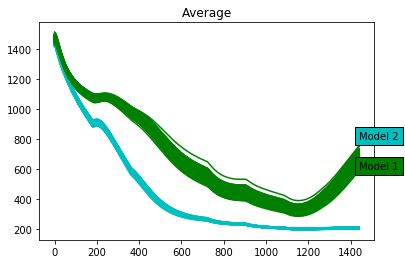

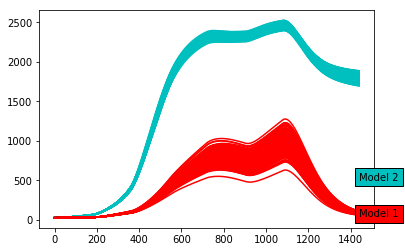

In [41]:
t = np.linspace(0,(24*60),round(24*60/5)+1)

plt.figure()
lines = plt.plot(t, GFP_M2, 'c')
plt.text((24*60)+1, 800, "Model 2", bbox=dict(facecolor='c'))
plt.title("Average")
lines2 = plt.plot(t, GFP_M1, 'g')
plt.text((24*60)+1, 600, "Model 1", bbox=dict(facecolor='g'))

plt.show()
plt.figure()
plt.plot(t, RFP_M2, 'c')

plt.text((24*60)+1, 500, "Model 2", bbox=dict(facecolor='c'))
plt.text((24*60)+1, 40, "Model 1", bbox=dict(facecolor='r'))
plt.plot(t, RFP_M1, 'r')
plt.show()

### Check utility decomposition results

In [ ]:
# Gaussian Process Regression and Reduction

# Means and standard deviations for each time point for each species and for each model
tgp = np.linspace(0,(24*60),(24*60/5)+1)

muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
sdR3 = RFP_M2.std(axis = 1)
muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
sdG3 = GFP_M2.std(axis = 1)
muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
sdR2 = RFP_M1.std(axis = 1)
muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
sdG2 = GFP_M1.std(axis = 1)

# Gaussian Process regression
gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
gR3.findhyperparameters(noruns=15)
gR3.predict(tgp)

gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
gG3.findhyperparameters(noruns=15)
gG3.predict(tgp)

gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
gR2.findhyperparameters(noruns=15)
gR2.predict(tgp)

gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
gG2.findhyperparameters(noruns=15)
gG2.predict(tgp)



In [ ]:
muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R2.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G2.predict(tref)

In [ ]:
bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
u_B = (bdR+bdG)/2

In [ ]:
print("The BD for RFP is: ", str(bdR))
print("The BD for GFP is: ", str(bdG))
print("The average BD is: ", str(u_B))